## A sentiment analysis on tweets related to E-levy.

#### This project seems to analyze the general consensus on the introduction of e-levy (electronic levy) charges by the Ghana Government on digital transactions. 

It uses the ------ NLP model to analyze the sentiments of hundreds of tweets scraped from twitter.

Importing first libraries <br>
<ul>
<li>snscrape ---> a scraper for social networking services </li>
<li>pandas ---> an open source data analysis and manipulation tool </li> 
<li>re ---> library for string manipulation</li>
</ul>

In [195]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import itertools
import re
import preprocessor as p


import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize

lemmatizer = nltk.stem.WordNetLemmatizer()
stop_words = set(stopwords.words('english'))



[nltk_data] Downloading package wordnet to C:\Users\Innocent
[nltk_data]     Anyaele\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Innocent
[nltk_data]     Anyaele\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


we build our query here by gathering e-levy related tweets from when it was first announced (2022/09/20)
we ran the query for may, june, july, august
we store our gathered tweets in a csv file -> streams.csv

In [233]:
def scrapeTweets(query, file):        
    
    tweets = []
    limit = 200

    data = sntwitter.TwitterSearchScraper(query).get_items()
    for tweet in data:
        if len(tweets) == limit:
            break
        else:
            tweet_text = tweet.content
            tweets.append([tweet.id, tweet_text, tweet.date])
            
    df = pd.DataFrame(tweets, columns=['id', 'Tweet', 'Date'])

    df.to_csv(file, index=False, columns=['id','Tweet','Date'])
    
    
may_query = '"e-levy" lang:en until:2022-09-20 since:2022-05-01 -filter:links'  # may
june_query = '"e-levy" lang:en until:2022-09-20 since:2022-06-01 -filter:links'  # june
july_query = '"e-levy" lang:en until:2022-09-20 since:2022-07-01 -filter:links'  # july
august_query = '"e-levy" lang:en until:2022-09-20 since:2022-08-01 -filter:links'  # august

scrapeTweets(august_query, 'august.csv')

Our tweet containes 200 rows each for four months -> 800, each row containing the tweet id, tweet content and the tweet date.
We print the first 5 tweets
We see our tweets, contains a lot of unneccessary data for analysis, so we preprocess it in the next step

In [234]:
may_df = pd.read_csv('may.csv')
june_df = pd.read_csv('june.csv')
july_df = pd.read_csv('july.csv')
august_df = pd.read_csv('august.csv')

df = pd.concat([may_df,june_df,july_df,august_df], axis=0)

print(df.shape)
print(df['Tweet'].head(5))

(1100, 3)
0    @edburtler @shamimamuslim Notice that Shamima ...
1    @edburtler @shamimamuslim QUESTION: \nWhy was ...
2    @FrankOw18664478 @hearttooclean @mandemthe1st ...
3    @FrankOw18664478 @hearttooclean @mandemthe1st ...
4    @FrankOw18664478 @bra_Kofi__ @hearttooclean @m...
Name: Tweet, dtype: object


The preprocessing stage involves cleaning up our tweets with a regex function by removing links, tags and whitespaces.

We also leverage the NLTK library to remove stop words such as "and", "or", "in"

After we print some of our tweets, it looks much more cleaner than before

In [240]:
def tweet_preprocessing(tweet):
    # regex cleanup
    tweet = re.sub(r"^https://t.co/[A-Za-z0-9]*\s", " ", tweet)
    tweet = re.sub(r"\s+https://t.co/[a-zA-Z0-9]*\s", " ", tweet)
    tweet = re.sub(r"\s+https://t.co/[a-zA-Z0-9]*$", " ", tweet)
    tweet = re.sub("\.\.+", " ", tweet)
    tweet = re.sub("-$", "", tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = re.sub(r"^ +", "", tweet)
    tweet = re.sub(r"  +", " ", tweet)
    
    # use preprocessing library to clean
    tweet = p.clean(tweet)
    tweet = tweet.lower()
    
    # tokenize
    token_tweet = word_tokenize(tweet)
    filtered = [w for w in token_tweet if not w.lower() in stop_words]
    filtered_array  = []
    
    # remove stopwords
    for w in token_tweet:
        if w not in stop_words:
            filtered_array.append(w)
                 
    
    return ' '.join(filtered_array)


# applying our pre processing function to our tweet
df['Tweet'] = df['Tweet'].apply(lambda x: tweet_preprocessing(x))
print (df['Tweet'].tail(5)) 


195    ghanapresidency imposition elevy also squeezin...
196    ayemeevee832 kawkwardness theooeeoo f00lishnes...
197                   wait get charged elevy bank momoei
198    scotloksh ashanti_kingdom suffering go attack ...
199           kwasivypa id rather pay elevy buy pork lol
Name: Tweet, dtype: object


##### Using the BERT Model

The BERT Model is a transformer based machine learning technique for natural language processing pre-training developed by Google. -> Wikipedia

We import the AutoTokenizer and the AutoModel for Sequence Classification

In [241]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')


We import Torch (an open source machine learning framework that can be used for natural language processing) and create a function that will leverage our tokenizer and model to find the sentiment score of a particular tweet. The score will return an array of scores will be computed on using torch.argmax function to find the appropriate sentiment score.

The score will fall in the range 1 - 3.
1 being negative sentiment and 3 being position sentiment with 2 a neutral sentiment.

Let's try this function on the text "I hate this" to test our model.

It returns 1 (a negative sentiment).

We try function on the text "I love this".

It returns a 3 (a positive sentiment)



In [242]:
import torch

def sentiment_score(tweet):
    tokens = tokenizer.encode(tweet, return_tensors='pt')
    result = model(tokens)
    result.logits
    # print (result.logits)
    return (int(torch.argmax(result.logits))+1)

sentiment_score('I hate this')
# sentiment_score('i love this')

1

We apply our sentiment score function on a newly created column called sentiment score 

In [243]:
df['sentiment_score'] = df['Tweet'].apply(lambda x: sentiment_score(x))

In [244]:
df.tail(10)

,id,Tweet,Date,sentiment_score
190,1570678904330788864,otuoserebuor papakwesi_jr rate npp nonsense fo...,2022-09-16 07:40:07+00:00,1
191,1570678478617411584,papakwesi_jr herhh make steady wai kon far art...,2022-09-16 07:38:25+00:00,4
192,1570669218412240900,dey send cedis koraa dem go charge elevy,2022-09-16 07:01:37+00:00,1
193,1570669002053263362,kawkwardness ayemeevee832 theooeeoo saw servin...,2022-09-16 07:00:46+00:00,3
194,1570662263065030657,miss apology,2022-09-16 06:33:59+00:00,1
195,1570634732387569664,ghanapresidency imposition elevy also squeezin...,2022-09-16 04:44:35+00:00,1
196,1570580273183731712,ayemeevee832 kawkwardness theooeeoo f00lishnes...,2022-09-16 01:08:11+00:00,3
197,1570556209807372289,wait get charged elevy bank momoei,2022-09-15 23:32:34+00:00,1
198,1570526434309046274,scotloksh ashanti_kingdom suffering go attack ...,2022-09-15 21:34:15+00:00,1
199,1570523525232095233,kwasivypa id rather pay elevy buy pork lol,2022-09-15 21:22:41+00:00,3


In [245]:
df['sentiment_score'].describe()

count    1100.000000
mean        1.922727
std         1.551198
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max         5.000000
Name: sentiment_score, dtype: float64

We add a newly created column with the text equivalent of our score.
1 - negative
2 - neutral
3 - positive

In [246]:
def get_sentiment(x):
    if x == 1:
        return 'Negative'
    if x == 2:
        return 'Neutral'
    if x == 3:
        return "Positive"
    
df['sentiment'] = df['sentiment_score'].apply(lambda x: get_sentiment(x))

df['sentiment'].tail(10)

190    Negative
191        None
192    Negative
193    Positive
194    Negative
195    Negative
196    Positive
197    Negative
198    Negative
199    Positive
Name: sentiment, dtype: object

Our sentiment count, shows 780 negatives, 86 positives, 24 neutrals

In [254]:
sentiment_count = (df['sentiment'].value_counts())
sentiment_count = pd.DataFrame({'Sentiments' : sentiment_count.values, 'Count': sentiment_count.index})
print (sentiment_count)

   Sentiments     Count
0         780  Negative
1          86  Positive
2          24   Neutral


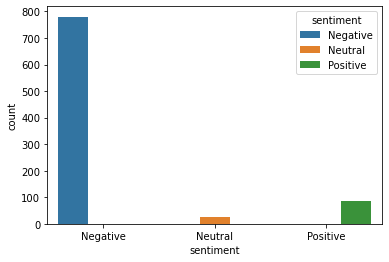

In [257]:
import seaborn as sns

sentiment_count_chart = sns.countplot(x='sentiment', data=df, hue='sentiment')
sentiment_count_chart.get_figure().savefig('sentiment_count_chart.png')